In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [7]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
len(dataset)

501

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[7 1 7 2 3 9 4 5 7 5 5 0 5 2 9 2 3 6 2 4 1 7 0 4 0 5 8 4 9 9 9 0]


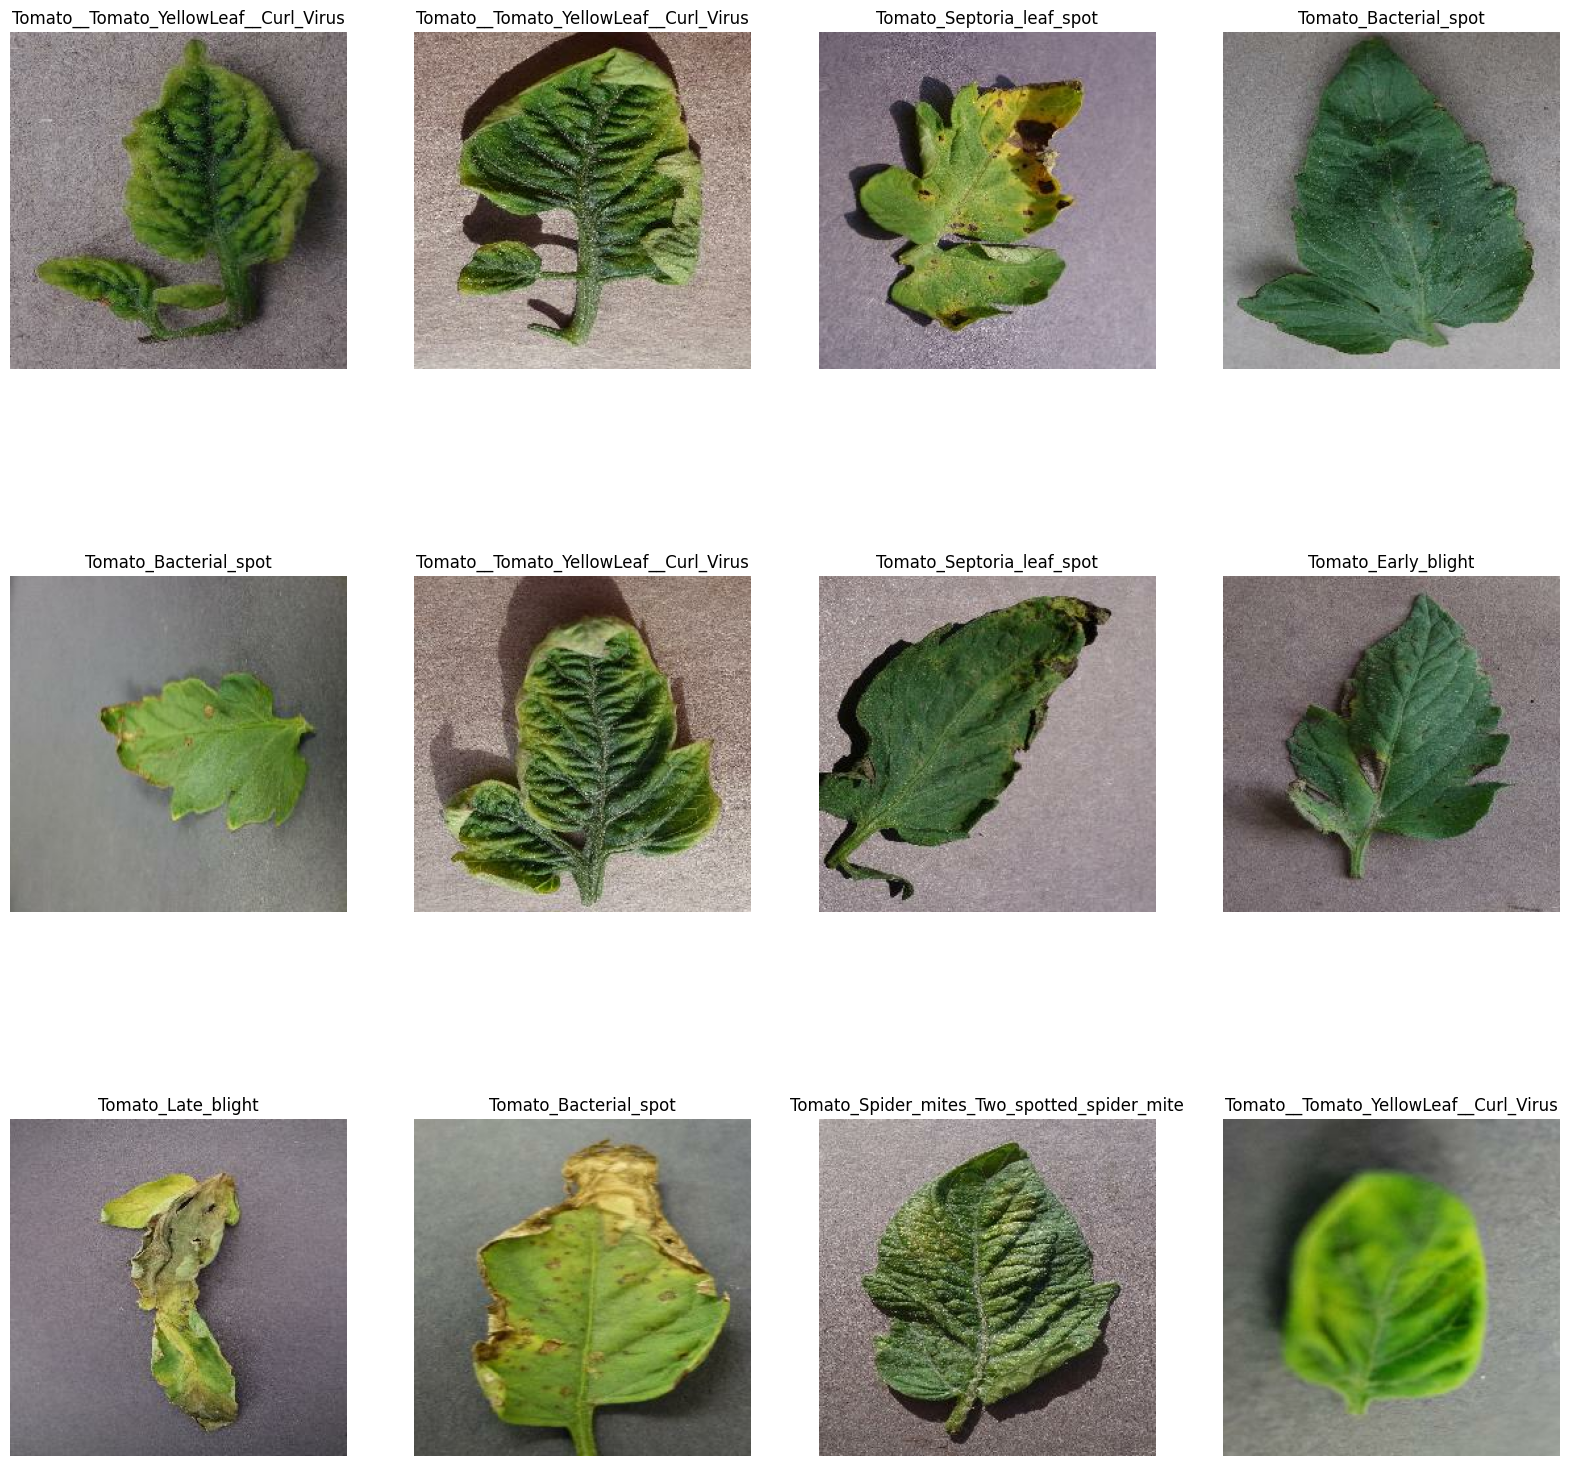

In [14]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [15]:
len(dataset)

501

In [16]:
501*32

16032

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [17]:
train_size = 0.8
len(dataset)*train_size

400.8

In [18]:
train_ds = dataset.take(400)
len(train_ds)

400

In [19]:
test_ds = dataset.skip(400)
len(test_ds)

101

In [23]:
val_size=0.1
len(dataset)*val_size

50.1

In [24]:
val_ds = test_ds.take(50)
len(val_ds)

50

In [25]:
test_ds = test_ds.skip(50)
len(test_ds)

51

In [31]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=200000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [32]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [33]:
len(train_ds)

400

In [34]:
len(val_ds)

50

In [35]:
len(test_ds)

51

In [36]:
train_ds = train_ds.cache().shuffle(16000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(16000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(16000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [41]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [42]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [48]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50


2025-02-25 18:01:22.005335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:29: Filling up shuffle buffer (this may take a while): 372 of 200000
2025-02-25 18:01:33.694697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-02-25 18:01:33.697471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:36: Filling up shuffle buffer (this may take a while): 1 of 16000
2025-02-25 18:01:33.833474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


400/400 ━━━━━━━━━━━━━━━━━━━━ 178s 381ms/step - accuracy: 0.3040 - loss: 1.9225 - val_accuracy: 0.5775 - val_loss: 1.2683
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 145s 362ms/step - accuracy: 0.5828 - loss: 1.2120 - val_accuracy: 0.6463 - val_loss: 1.0132
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 145s 363ms/step - accuracy: 0.6971 - loss: 0.8826 - val_accuracy: 0.6481 - val_loss: 1.1202
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 145s 361ms/step - accuracy: 0.7503 - loss: 0.7099 - val_accuracy: 0.7469 - val_loss: 0.7840
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 145s 361ms/step - accuracy: 0.8032 - loss: 0.5695 - val_accuracy: 0.8413 - val_loss: 0.4546
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 145s 363ms/step - accuracy: 0.8387 - loss: 0.4587 - val_accuracy: 0.8294 - val_loss: 0.4979
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 147s 367ms/step - accuracy: 0.8651 - loss: 0.3794 - val_accuracy: 0.7937 - val_loss: 0.6744
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 146s 365ms/step - accuracy: 0.8715 - loss: 0.35

In [49]:
scores = model.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.9337 - loss: 0.2075


In [50]:
scores

[0.18750673532485962, 0.9405637383460999]

In [51]:
history

In [52]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 400}

In [53]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [54]:
type(history.history['loss'])

list

In [55]:
len(history.history['loss'])

50

In [56]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.6608750820159912,
 1.1030199527740479,
 0.8270822763442993,
 0.6615107655525208,
 0.5374314188957214]

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

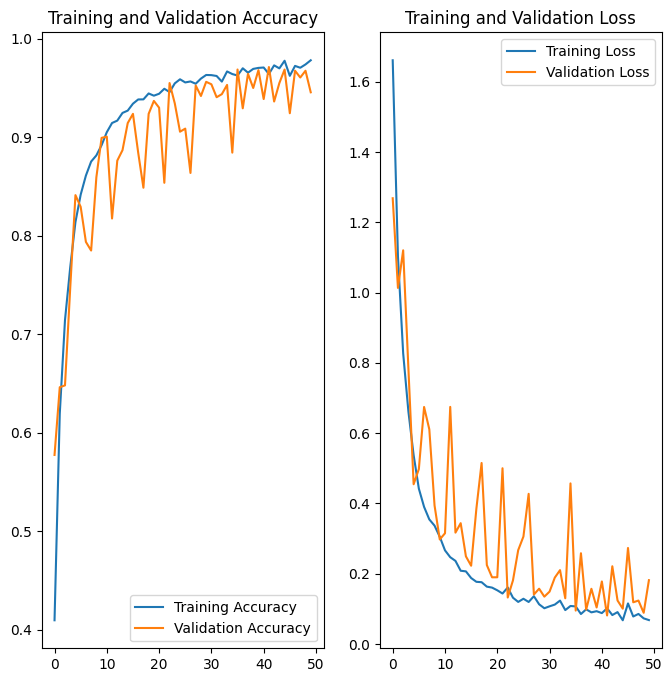

In [58]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
predicted label: Tomato_Late_blight


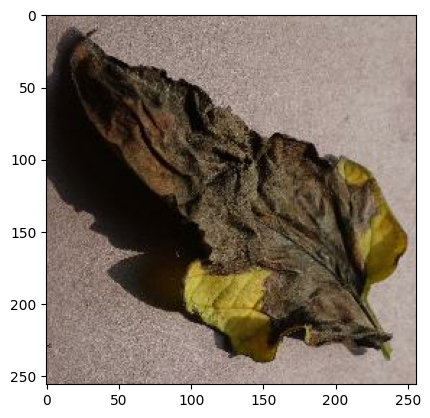

In [59]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2025-02-25 20:30:58.060934: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


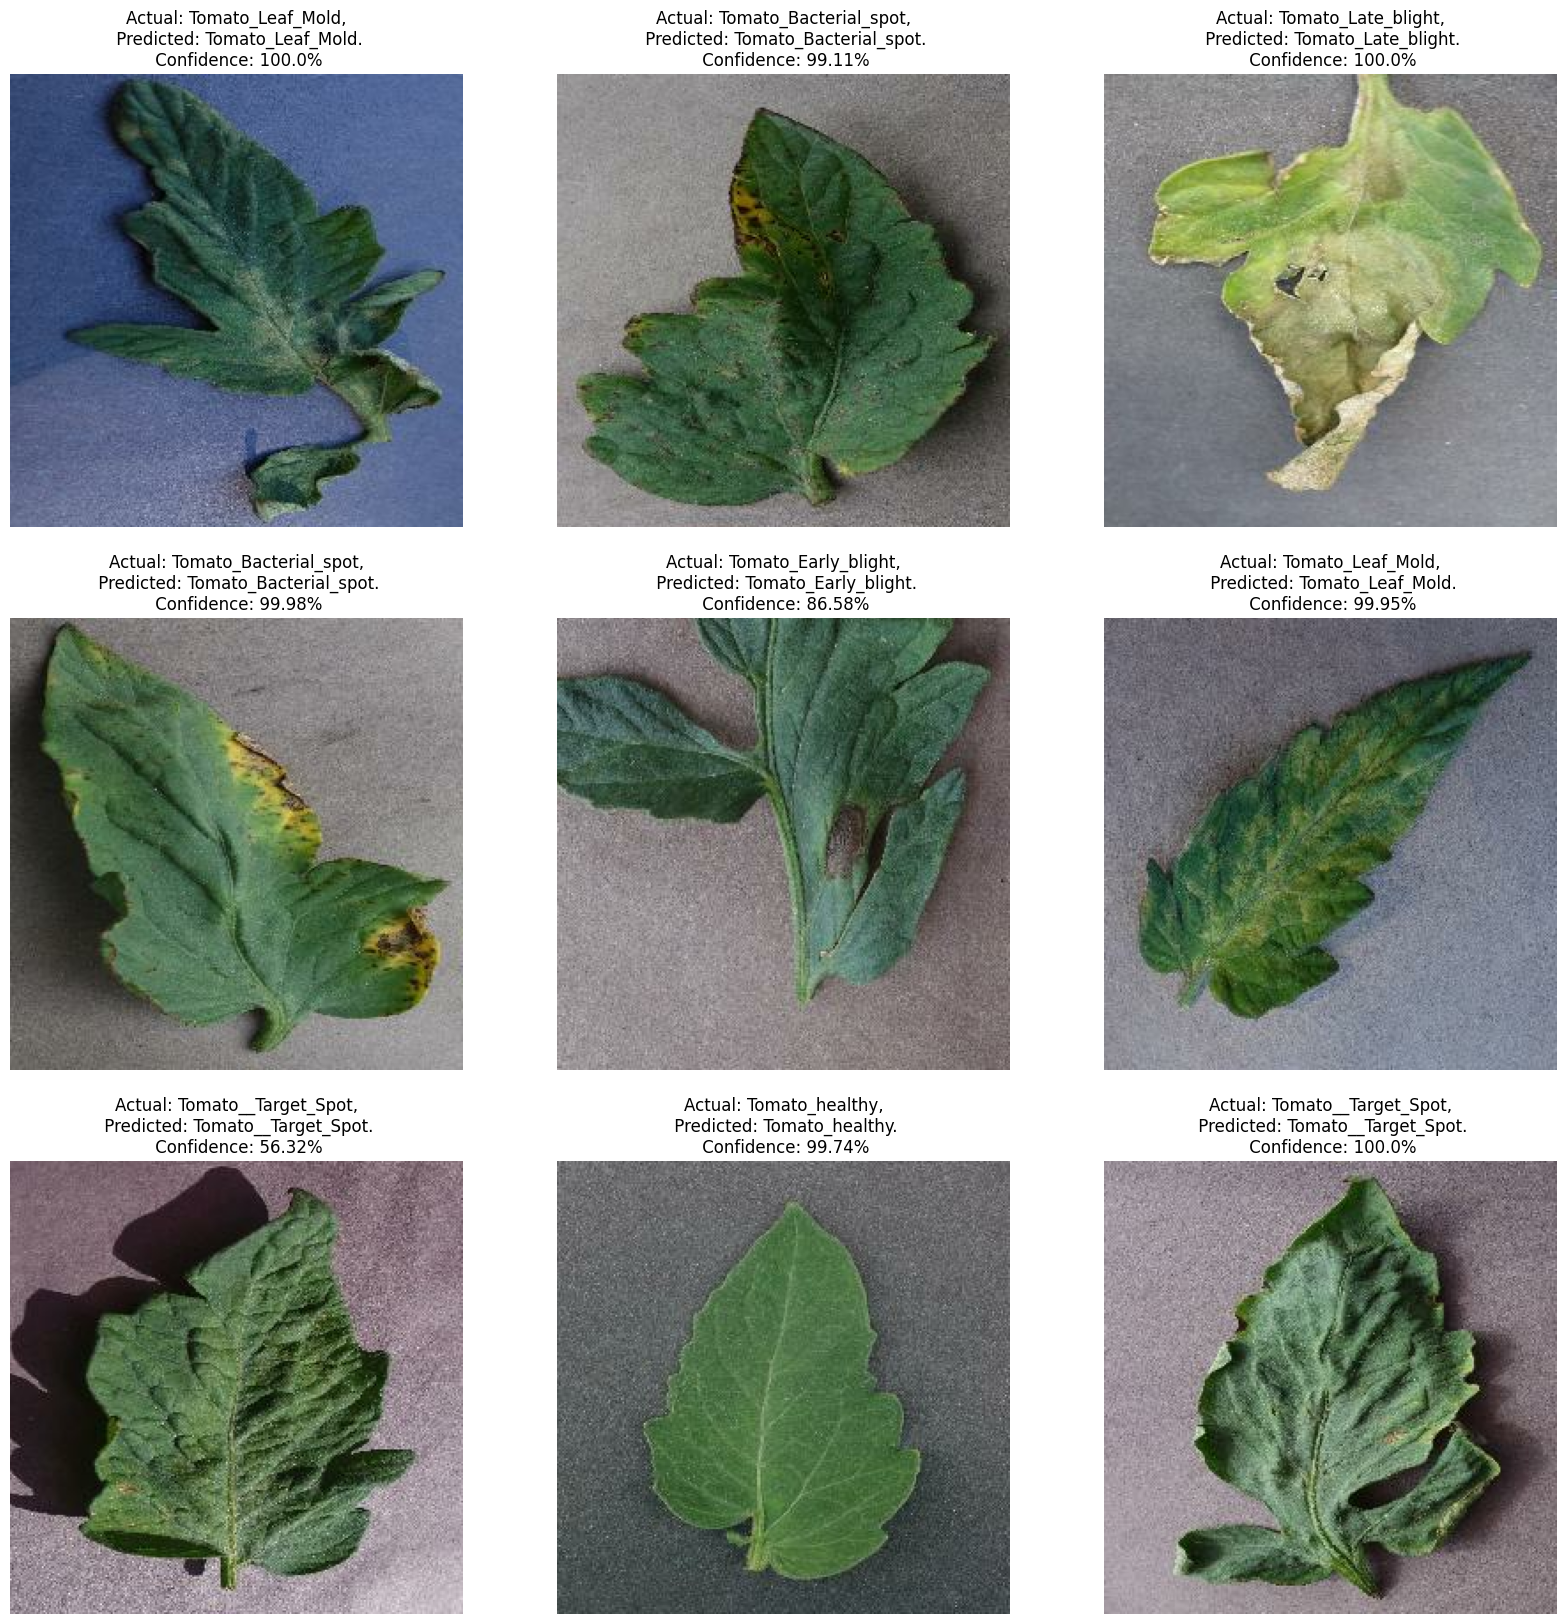

In [61]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [67]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
os.makedirs(f"../models/{model_version}", exist_ok=True)
model.export(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3/assets


INFO:tensorflow:Assets written to: ../models/3/assets


Saved artifact at '../models/3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_56')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  13289151120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13289151696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13289152272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13289152848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13289152080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13289153616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13289153040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13289154384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13289153808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13289155152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13289154576: TensorSpec(shape=(), dtype=tf.resource, na

In [69]:
model.save("../tomatoes.h5")